In [1]:
import math
import torch
import json
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from modules.train import *
from modules.dataset import *
from modules.network import *
from torch import cuda, device, save

In [2]:
# other params - test
!mkdir ./data/results
!mkdir ./images
out_dir = './data/results'
epochs = 10
batch_size = 1000
eval_batch_size = 10
clip = 0.25
bptt = 35
tied = True
log_interval = 1
seed = 42

mkdir: impossibile creare la directory "./data/results": File già esistente
mkdir: impossibile creare la directory "./images": File già esistente


In [3]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cpu


In [4]:
# Set local paths
images_path = "./images"
res_path = "./data/results"

# Dataset

## Load and preprocess data

The vocab object (stored in WordToIndex) is built based on the train dataset and is used to numericalize tokens into tensors. Starting from sequential data, the batchify() function arranges the dataset into columns,
trimming off any tokens remaining after the data has been divided into batches of size batch_size.

In [5]:
# Set the random seed manually for reproducibility.
_ = torch.manual_seed(seed)

In [6]:
# Fix minimum sentence length
min_len = 18
# Tokenize data
dataset = Bible('./data/bible.txt', min_len = min_len)
    
len(dataset)

21374

Mean sentence length: 31.432675212875456
Max sentence length: 102
Min sentence length: 18


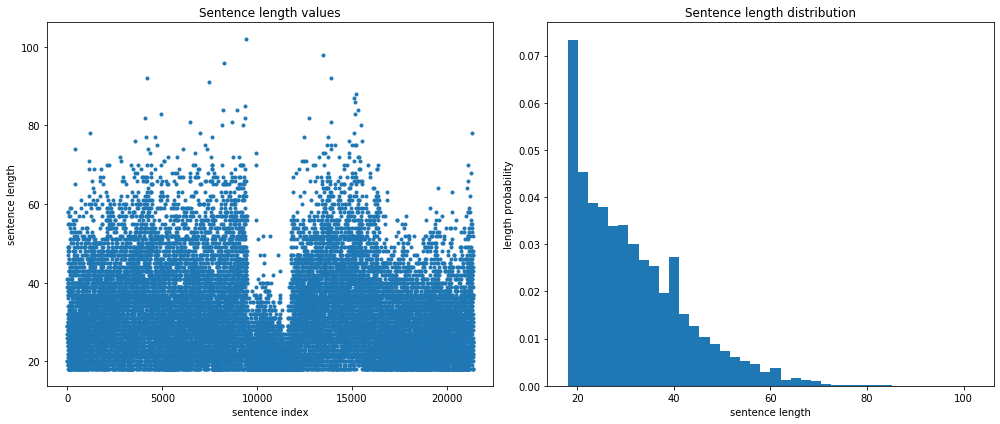

In [7]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs.ravel()
axs[0].set_title('Sentence length values')
axs[0].set_xlabel('sentence index')
axs[0].set_ylabel('sentence length')
_ = axs[0].plot(lengths, '.')
axs[1].set_title('Sentence length distribution')
axs[1].set_xlabel('sentence length')
axs[1].set_ylabel('length probability')
_ = axs[1].hist(lengths, bins=40, density=True)

print('Mean sentence length:', np.mean(lengths))
print('Max sentence length:', np.max(lengths))
print('Min sentence length:', np.min(lengths))

plt.tight_layout()
plt.savefig(images_path+f'/bible_{min_len}.png')
plt.show()

In [8]:
print(len(set(dataset.words)))

10775


In [9]:
# Define transformation 
dataset.transform = transforms.Compose([
    WordToIndex(dataset.words),
    ToTensor()
])

In [10]:
dataset[0]

tensor([10424,  2800,  3993,  3362,  1510,  6396,  5892, 10424,  2451,  7353,
        10424,  9294,  3362,  7722,  2800,  3451,  7752,  2800,  5960,  2495],
       dtype=torch.int32)

## Split data

In [11]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)


# Create batches
train_data = batchify(train_dataset, batch_size).to(device)
val_data = batchify(test_dataset, eval_batch_size).to(device)

# Transformer model

In [12]:
# Number of words
ntokens = len(dataset.words)

# Parameters
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Initialize network
net = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout)

# Optimizer
optimizer = torch.optim.Adam(net.parameters())

net.to(device)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=200, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=200, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=20

In [ ]:
# Loop over epochs.
best_val_loss = None

## Training
training_loss, validation_loss = [], []
for epoch in range(1, epochs+1):
    epoch_start_time = time.time()
    train(net, optimizer, loss_fn, train_data, ntokens, log_interval=1)
    val_loss = evaluate(net, val_data, ntokens)
    validation_loss.append(float(val_loss))

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
            'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                       val_loss, math.exp(val_loss)))
    print('-' * 89)



### Save all needed parameters
# Create output dir
#out_dir = Path(out_dir)
#out_dir.mkdir(parents=True, exist_ok=True)

# Save network parameters
# torch.save(model.state_dict(), out_dir / 'net_params.pth')


training_args=vars(args)
training_args['ntokens'] = ntokens

#with open(out_dir / 'training_json', 'w') as f:
#    json.dump(vars(args), f, indent=4)
#
## Save losses sequence dictionary
#loss_dict = {'training': training_loss,
#             'validation': validation_loss}
#
#with open(out_dir / 'loss.json', 'w') as f:
#    json.dump(loss_dict, f, indent=4)